In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [43]:
# Create the regression dataset
x_data = torch.tensor([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0], dtype=torch.float32, device=device)
y_data = torch.tensor([7.0, 5.0, 4.0, 2.0, 4.0, 3.0, 5.0], dtype=torch.float32, device=device)

# Reshape for neural network input (batch_size, input_features)
X = x_data.unsqueeze(1)  # Shape: (4, 1)
y = y_data.unsqueeze(1)  # Shape: (4, 1)




In [44]:
# Define MLP architecture for overfitting
class MLP(nn.Module):
    def __init__(self, input_size=1, hidden_sizes=[64, 64, 64], output_size=1, activation=nn.ReLU, device=device):
        super(MLP, self).__init__()
        
        # Build the network dynamically based on hidden_sizes
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(activation())
            prev_size = hidden_size
        
        # Add output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.network = nn.Sequential(*layers)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                # Use Kaiming uniform for ReLU activations
                nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
                # Initialize biases to zero
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, x):
        return self.network(x)



In [61]:
# Compare ReLU vs GELU convergence
print("=== ReLU vs GELU Convergence Comparison ===")

# Create two identical models with different activations
relu_model = MLP(input_size=1, hidden_sizes=[8 for _ in range(4)], output_size=1, activation=nn.ReLU).to(device)
gelu_model = MLP(input_size=1, hidden_sizes=[8 for _ in range(4)], output_size=1, activation=nn.GELU).to(device)

print(f"ReLU model parameters: {sum(p.numel() for p in relu_model.parameters())}")
print(f"GELU model parameters: {sum(p.numel() for p in gelu_model.parameters())}")

# Training setup
criterion = nn.MSELoss()
relu_optimizer = optim.AdamW(relu_model.parameters(), lr=0.01)
gelu_optimizer = optim.AdamW(gelu_model.parameters(), lr=0.01)

# Training both models
num_epochs = 10000
relu_losses = []
gelu_losses = []

relu_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    relu_optimizer, 
    mode='min', 
    factor=0.5, 
    patience=200, 
    threshold=1e-6,
)

gelu_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    gelu_optimizer, 
    mode='min', 
    factor=0.5, 
    patience=200, 
    threshold=1e-6,
)

total_t_relu = 0
total_t_gelu = 0

import time

print("\nTraining both models...")
for epoch in range(num_epochs):
    t_start = time.time()
    # Train ReLU model
    relu_outputs = relu_model(X)
    relu_loss = criterion(relu_outputs, y)
    relu_optimizer.zero_grad()
    relu_loss.backward()
    relu_optimizer.step()
    relu_scheduler.step(relu_loss)
    relu_losses.append(relu_loss.item())
    total_t_relu += time.time() - t_start
    
    # Train GELU model
    t_start = time.time()
    gelu_outputs = gelu_model(X)
    gelu_loss = criterion(gelu_outputs, y)
    gelu_optimizer.zero_grad()
    gelu_loss.backward()
    gelu_optimizer.step()
    gelu_scheduler.step(gelu_loss)
    gelu_losses.append(gelu_loss.item())
    total_t_gelu += time.time() - t_start
    # Print progress every 400 epochs
    if (epoch + 1) % 400 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  ReLU Loss: {relu_loss.item():.8f}')
        print(f'  GELU Loss: {gelu_loss.item():.8f}')
        print()

print(f"Final ReLU Loss: {relu_losses[-1]:.8f}")
print(f"Final GELU Loss: {gelu_losses[-1]:.8f}")

print(f"Total time for ReLU: {total_t_relu:.2f} seconds")
print(f"Total time for GELU: {total_t_gelu:.2f} seconds")



=== ReLU vs GELU Convergence Comparison ===
ReLU model parameters: 241
GELU model parameters: 241

Training both models...
Epoch [400/10000]
  ReLU Loss: 0.01353293
  GELU Loss: 0.00914319

Epoch [800/10000]
  ReLU Loss: 0.00066862
  GELU Loss: 0.00074660

Epoch [1200/10000]
  ReLU Loss: 0.00004327
  GELU Loss: 0.00002993

Epoch [1600/10000]
  ReLU Loss: 0.00002353
  GELU Loss: 0.00001403

Epoch [2000/10000]
  ReLU Loss: 0.00004846
  GELU Loss: 0.00000764

Epoch [2400/10000]
  ReLU Loss: 0.00001105
  GELU Loss: 0.00000404

Epoch [2800/10000]
  ReLU Loss: 0.00090098
  GELU Loss: 0.00000206

Epoch [3200/10000]
  ReLU Loss: 0.00000283
  GELU Loss: 0.00000105

Epoch [3600/10000]
  ReLU Loss: 0.00000279
  GELU Loss: 0.00000343

Epoch [4000/10000]
  ReLU Loss: 0.00000213
  GELU Loss: 0.00000050

Epoch [4400/10000]
  ReLU Loss: 0.00000170
  GELU Loss: 0.00000124

Epoch [4800/10000]
  ReLU Loss: 0.00000150
  GELU Loss: 0.00000017

Epoch [5200/10000]
  ReLU Loss: 0.00000139
  GELU Loss: 0.00000

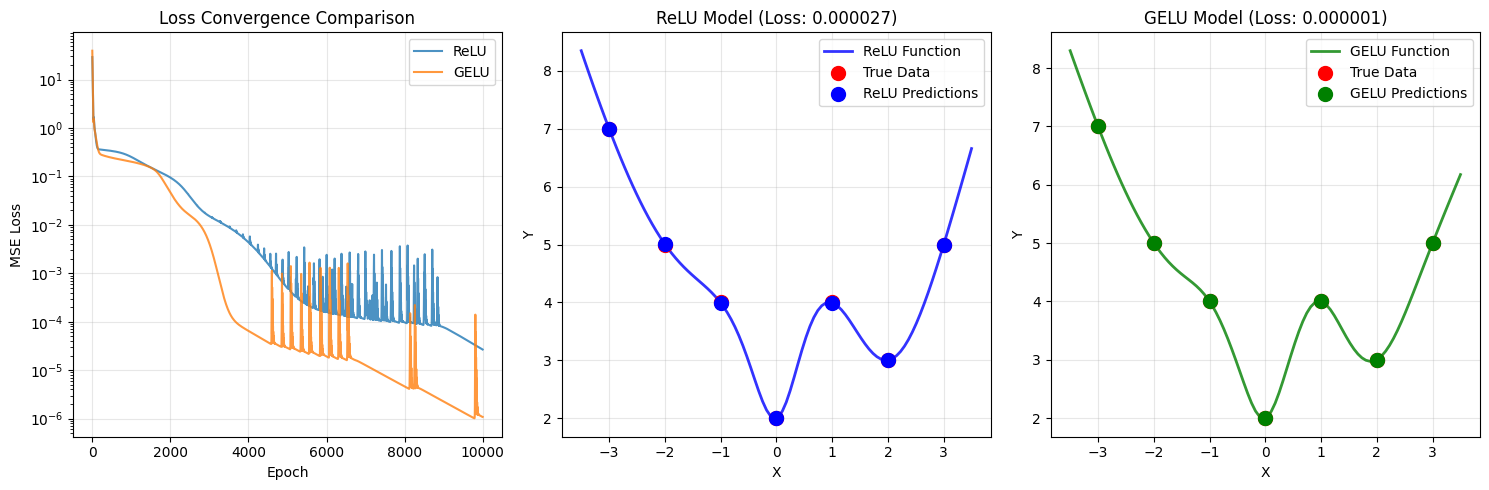

In [56]:
# Visualize the convergence comparison with smooth functions
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves comparison
plt.subplot(1, 3, 1)
plt.plot(relu_losses, label='ReLU', alpha=0.8)
plt.plot(gelu_losses, label='GELU', alpha=0.8)
plt.title('Loss Convergence Comparison')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# Create smooth x-values for plotting
x_smooth = torch.linspace(-3.5, 3.5, 100).unsqueeze(1).to(device)

# Plot 2: ReLU predictions vs targets with smooth function
plt.subplot(1, 3, 2)
relu_model.eval()
with torch.no_grad():
    relu_pred = relu_model(X)
    relu_smooth_pred = relu_model(x_smooth)

x_plot = X.squeeze().cpu().numpy()
y_plot = y.squeeze().cpu().numpy()
relu_pred_plot = relu_pred.squeeze().cpu().numpy()
relu_smooth_plot = relu_smooth_pred.squeeze().cpu().numpy()

# Plot smooth function
plt.plot(x_smooth.squeeze().cpu().numpy(), relu_smooth_plot, 'b-', linewidth=2, alpha=0.8, label='ReLU Function')

# Plot data points
plt.scatter(x_plot, y_plot, color='red', s=100, label='True Data', zorder=5)
plt.scatter(x_plot, relu_pred_plot, color='blue', s=100, label='ReLU Predictions', zorder=5)

plt.title(f'ReLU Model (Loss: {relu_losses[-1]:.6f})')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: GELU predictions vs targets with smooth function
plt.subplot(1, 3, 3)
gelu_model.eval()
with torch.no_grad():
    gelu_pred = gelu_model(X)
    gelu_smooth_pred = gelu_model(x_smooth)

gelu_pred_plot = gelu_pred.squeeze().cpu().numpy()
gelu_smooth_plot = gelu_smooth_pred.squeeze().cpu().numpy()

# Plot smooth function
plt.plot(x_smooth.squeeze().cpu().numpy(), gelu_smooth_plot, 'g-', linewidth=2, alpha=0.8, label='GELU Function')

# Plot data points
plt.scatter(x_plot, y_plot, color='red', s=100, label='True Data', zorder=5)
plt.scatter(x_plot, gelu_pred_plot, color='green', s=100, label='GELU Predictions', zorder=5)

plt.title(f'GELU Model (Loss: {gelu_losses[-1]:.6f})')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
